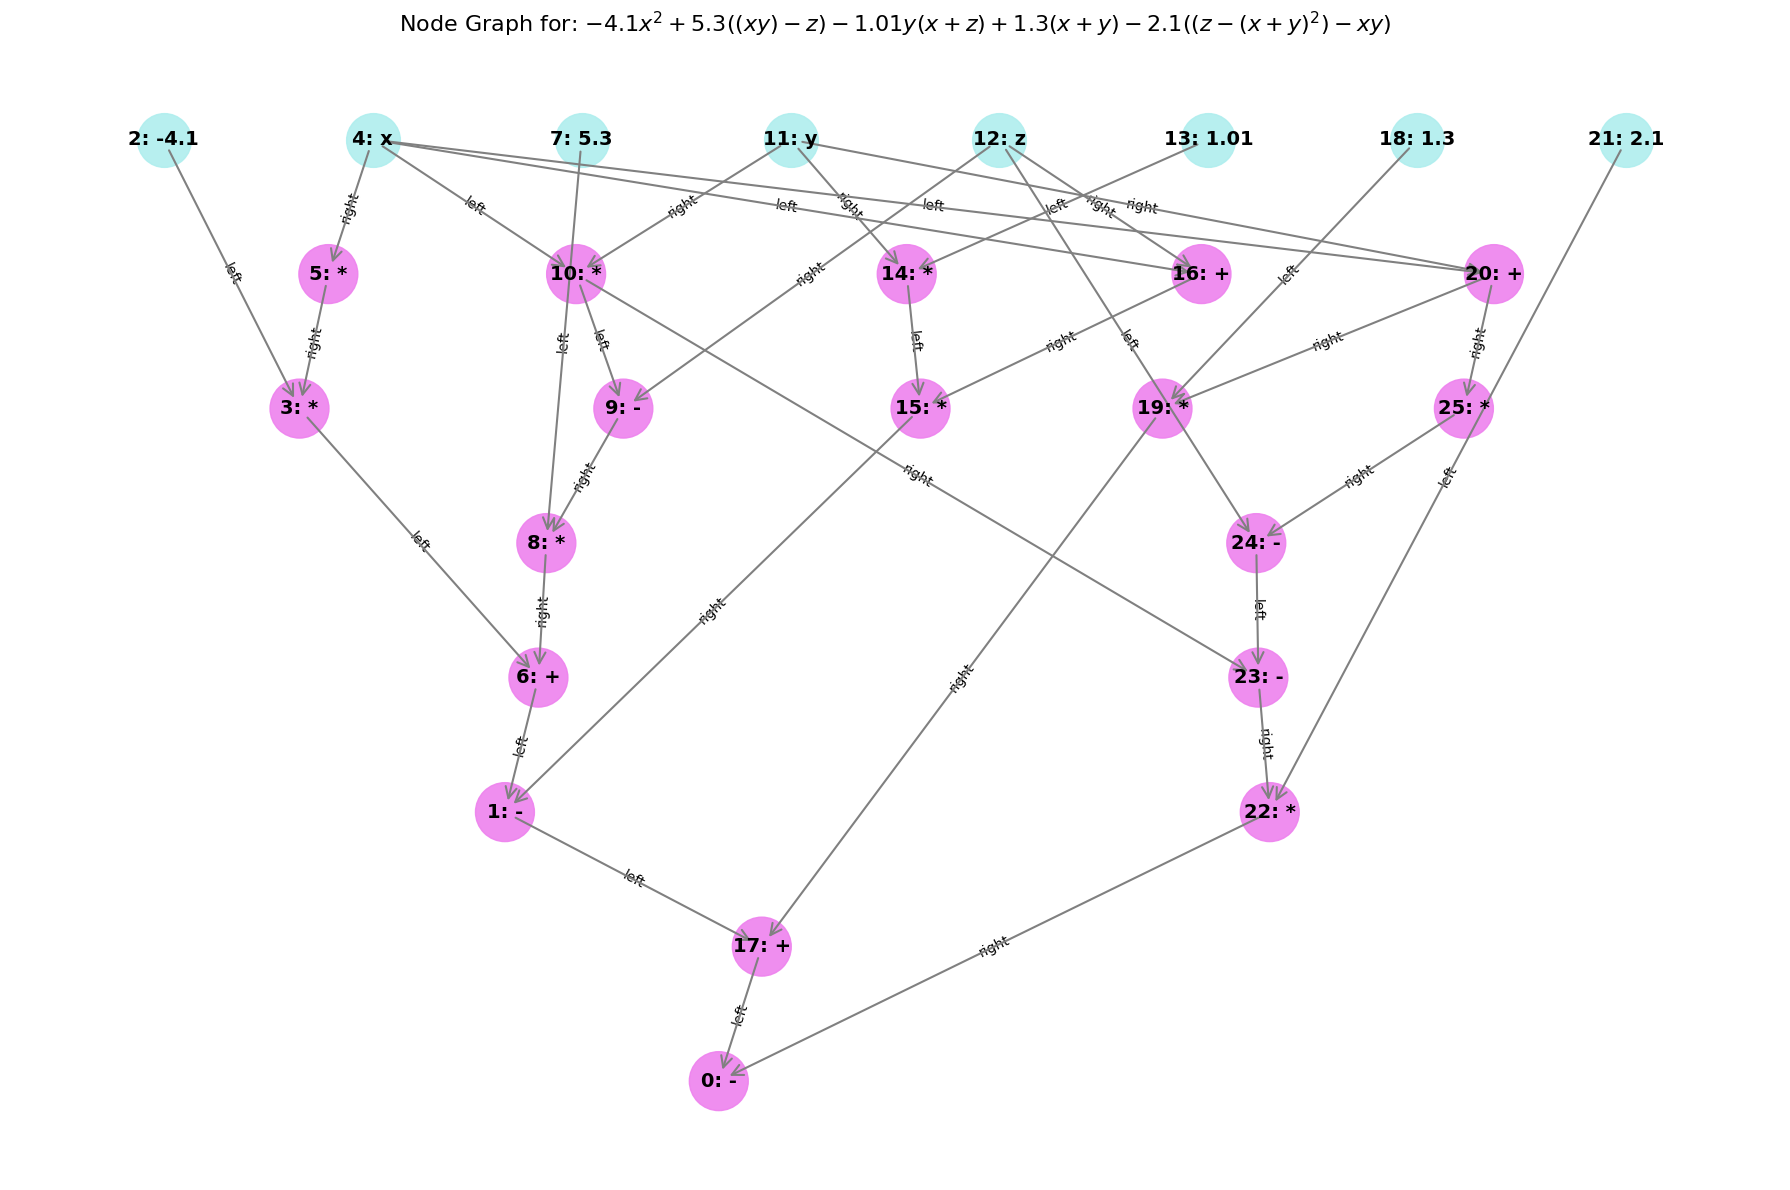

-4.1 (2, 3, '-') -4
5.3 (0, 2, '+') 5
1.01 (-7, 0, '+') 1.0078125
1.3 (-2, 0, '+') 1.25
2.1 (-3, 1, '+') 2.125


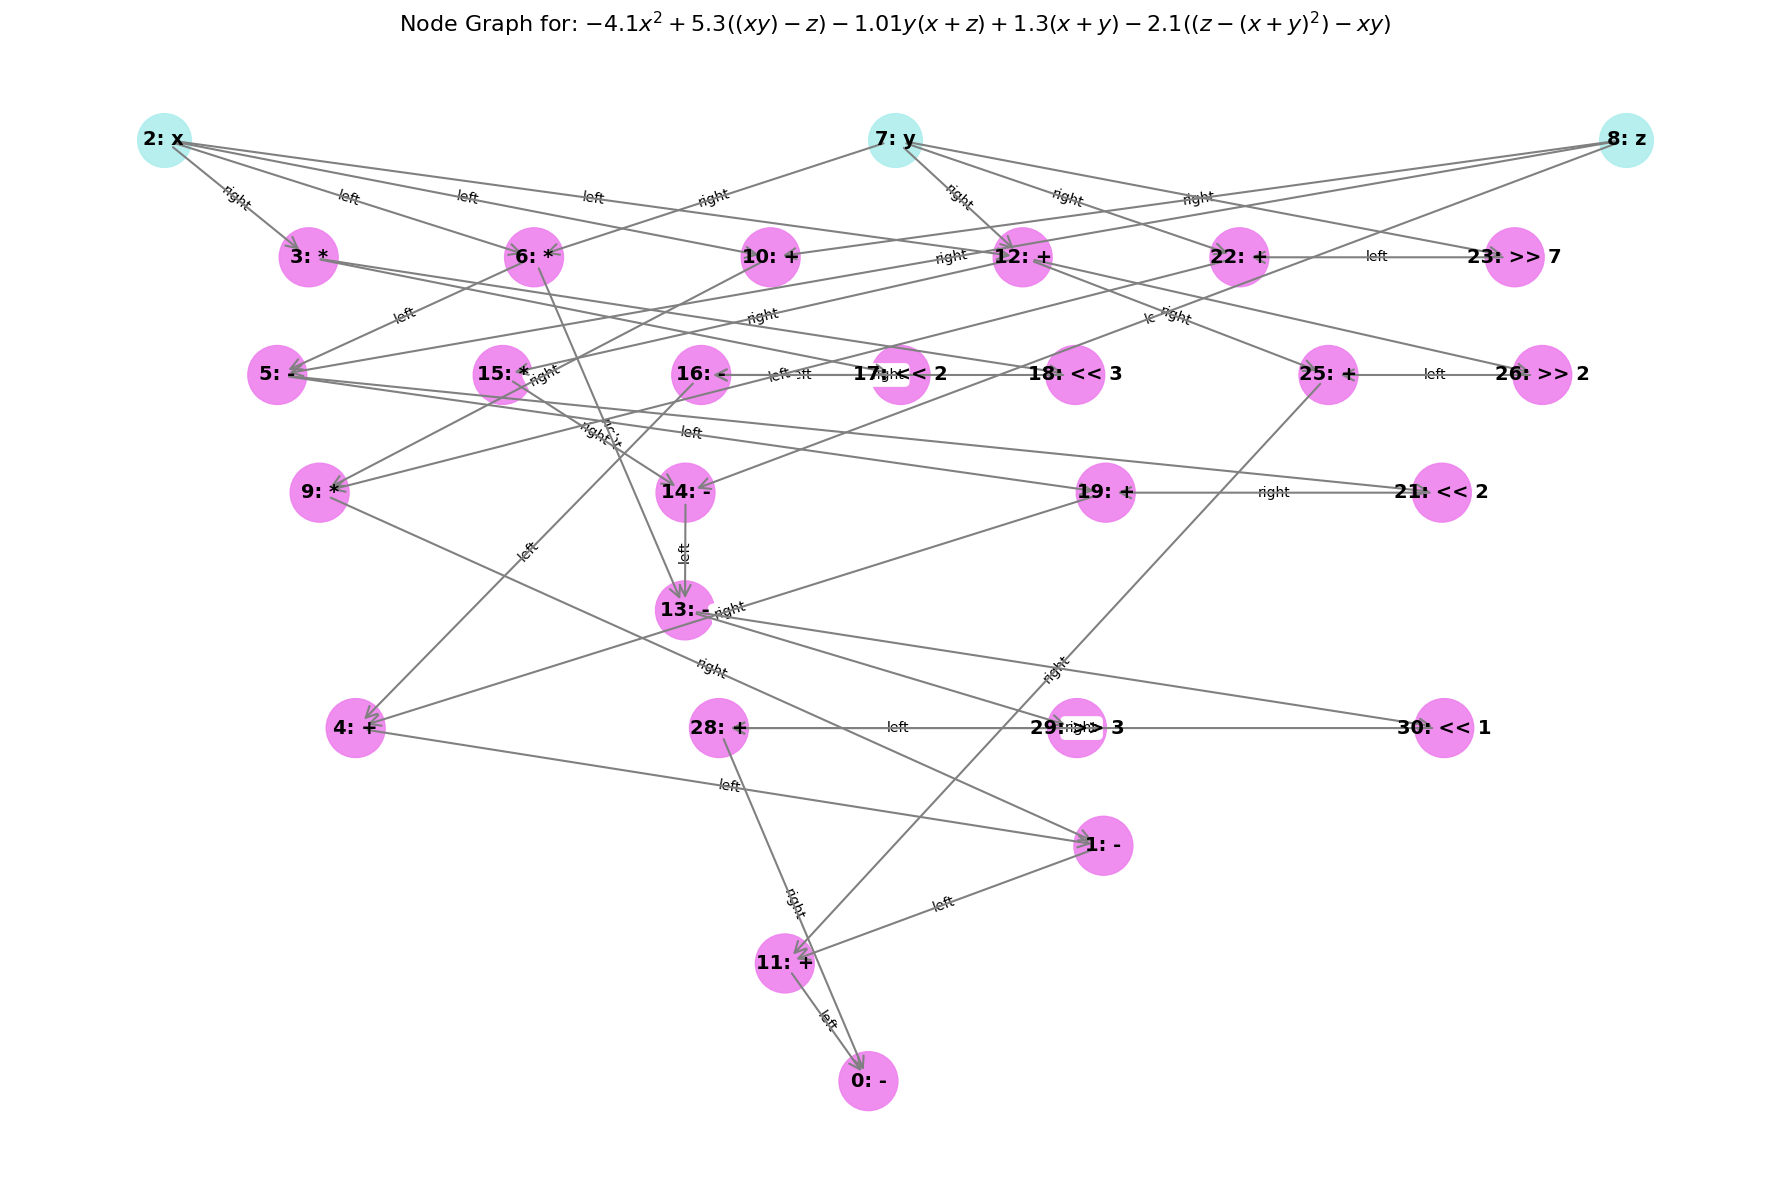

[[0], [1], [3], [4], [5], [6], [9], [10], [11], [12], [13], [14], [15], [16], [19], [22], [25], [28], [1, 11], [6, 13], [10, 9], [12, 15], [15, 14], [16, 4], [19, 4], [22, 9], [25, 11]]
[[0], [1], [3], [4], [5], [6], [9], [10], [11], [12], [13], [14], [15], [16], [19], [22], [25], [28], [1, 11], [6, 13], [10, 9], [12, 15], [15, 14], [16, 4], [19, 4], [22, 9], [25, 11]]
Number of DSP Blocks:  14
[[0], [1], [3], [4], [5], [6], [9], [10], [11], [12], [13], [14], [15], [16], [19], [22], [25], [28], [1, 11], [6, 13], [10, 9], [12, 15], [15, 14], [16, 4], [19, 4], [22, 9], [25, 11]]


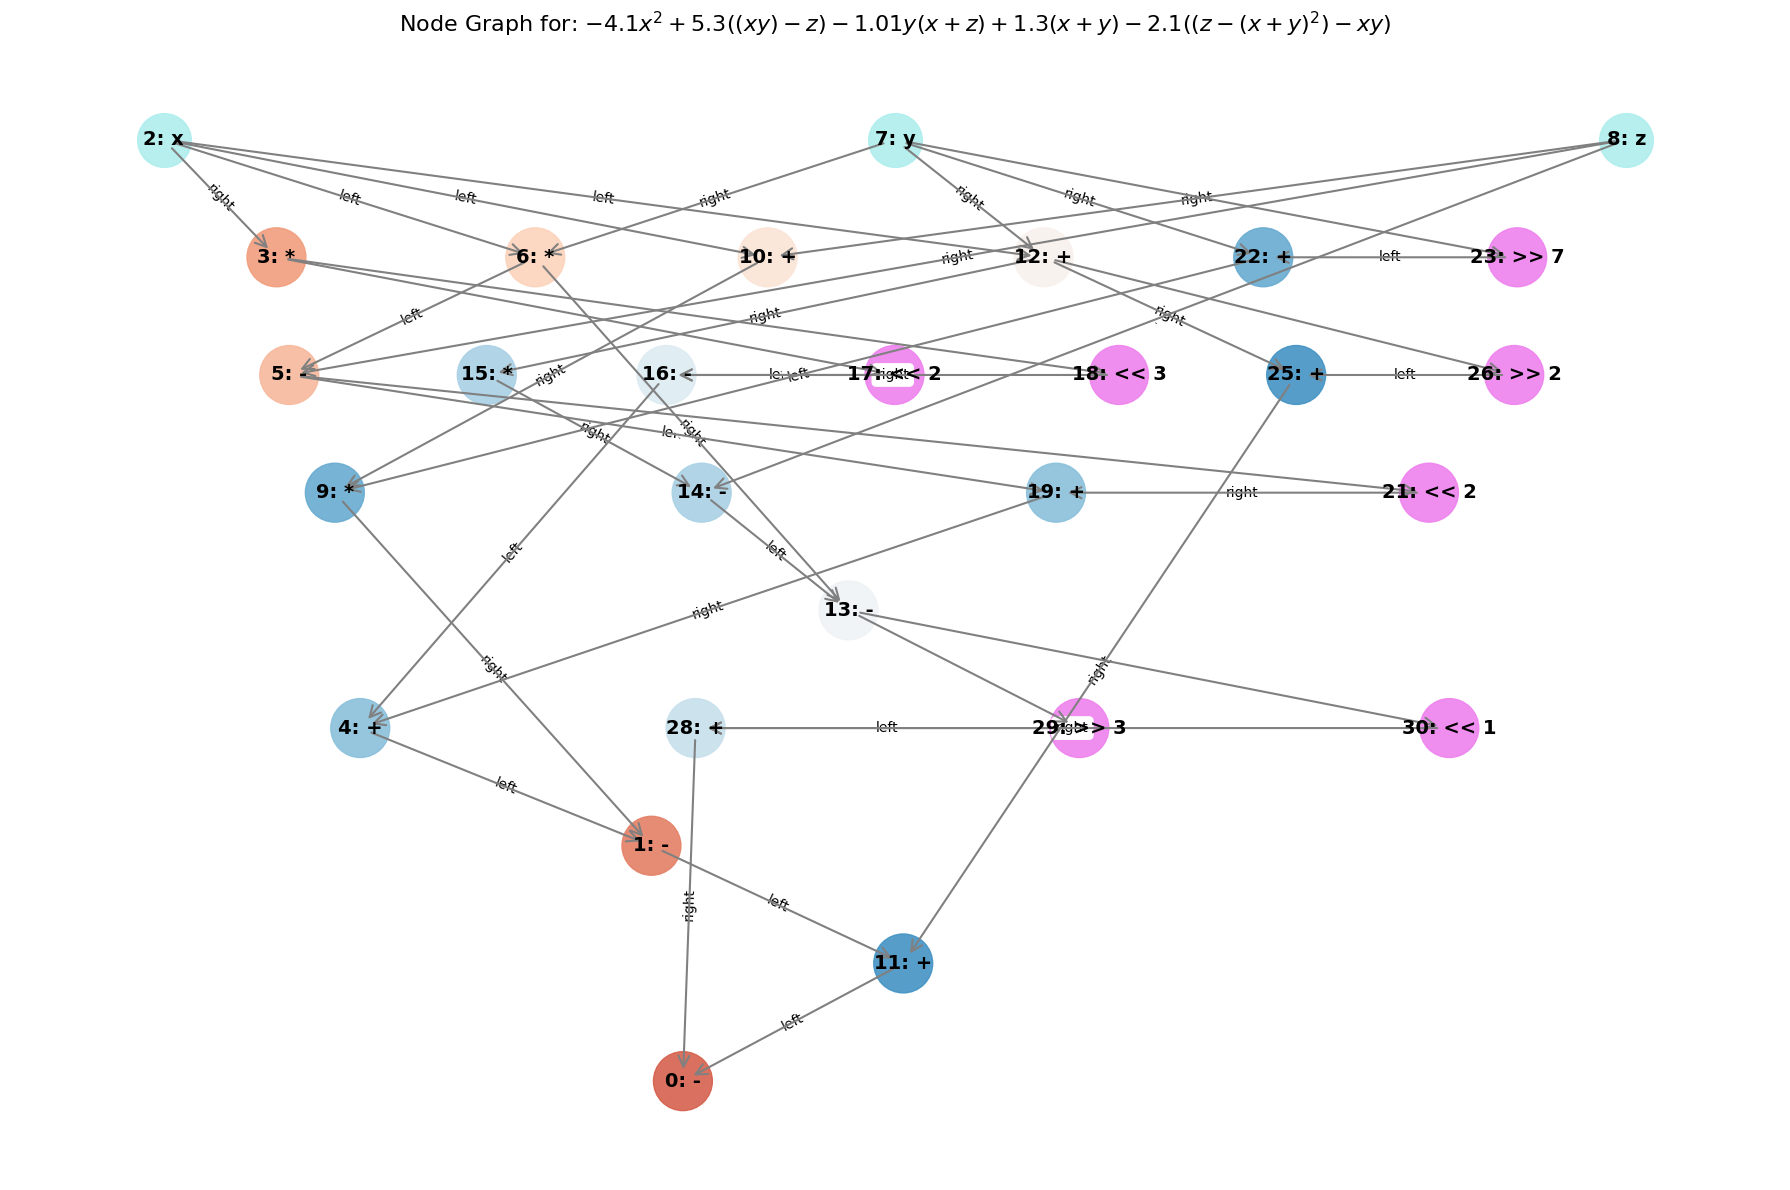

{2: 0, 7: 0, 8: 0, 3: 1, 6: 1, 12: 1, 23: 1, 10: 1, 17: 2, 18: 2, 5: 2, 15: 2, 26: 2, 22: 1, 16: 2, 21: 3, 14: 3, 25: 2, 9: 3, 19: 3, 13: 4, 4: 5, 29: 5, 30: 5, 1: 6, 28: 5, 11: 7, 0: 8}
8 0
[2, 7, 8]
[]
7 1
[3, 6, 12, 23, 10, 22]
[23]
2 0
7 0
8 0
3 1
6 1
12 1
23 1
10 1
17 2
18 2
5 2
15 2
26 2
22 1
16 2
21 3
14 3
25 2
9 3
19 3
13 4
4 5
29 5
30 5
1 6
28 5
11 7
0 8
6 3
[17, 18, 5, 15, 26, 16, 25]
[17, 18, 26]
2 0
7 0
8 0
3 2
6 2
12 2
23 1
10 2
17 3
18 3
5 3
15 3
26 3
22 2
16 3
21 4
14 4
25 3
9 4
19 4
13 5
4 6
29 6
30 6
1 7
28 6
11 8
0 9
5 5
[21, 14, 9, 19]
[21]
2 0
7 0
8 0
3 2
6 2
12 2
23 1
10 2
17 3
18 3
5 4
15 4
26 3
22 2
16 4
21 5
14 5
25 4
9 5
19 5
13 6
4 7
29 7
30 7
1 8
28 7
11 9
0 10
4 7
[13]
[]
3 8
[4, 29, 30, 28]
[29, 30]
2 0
7 0
8 0
3 2
6 2
12 2
23 1
10 2
17 3
18 3
5 4
15 4
26 3
22 2
16 4
21 5
14 6
25 4
9 6
19 6
13 7
4 8
29 8
30 8
1 9
28 8
11 10
0 11
2 10
[1]
[]
1 11
[11]
[]
0 12
[0]
[]
{2: 0, 7: 0, 8: 0, 3: 2, 6: 2, 12: 2, 23: 1, 10: 2, 17: 3, 18: 3, 5: 4, 15: 4, 26: 3, 22: 2, 

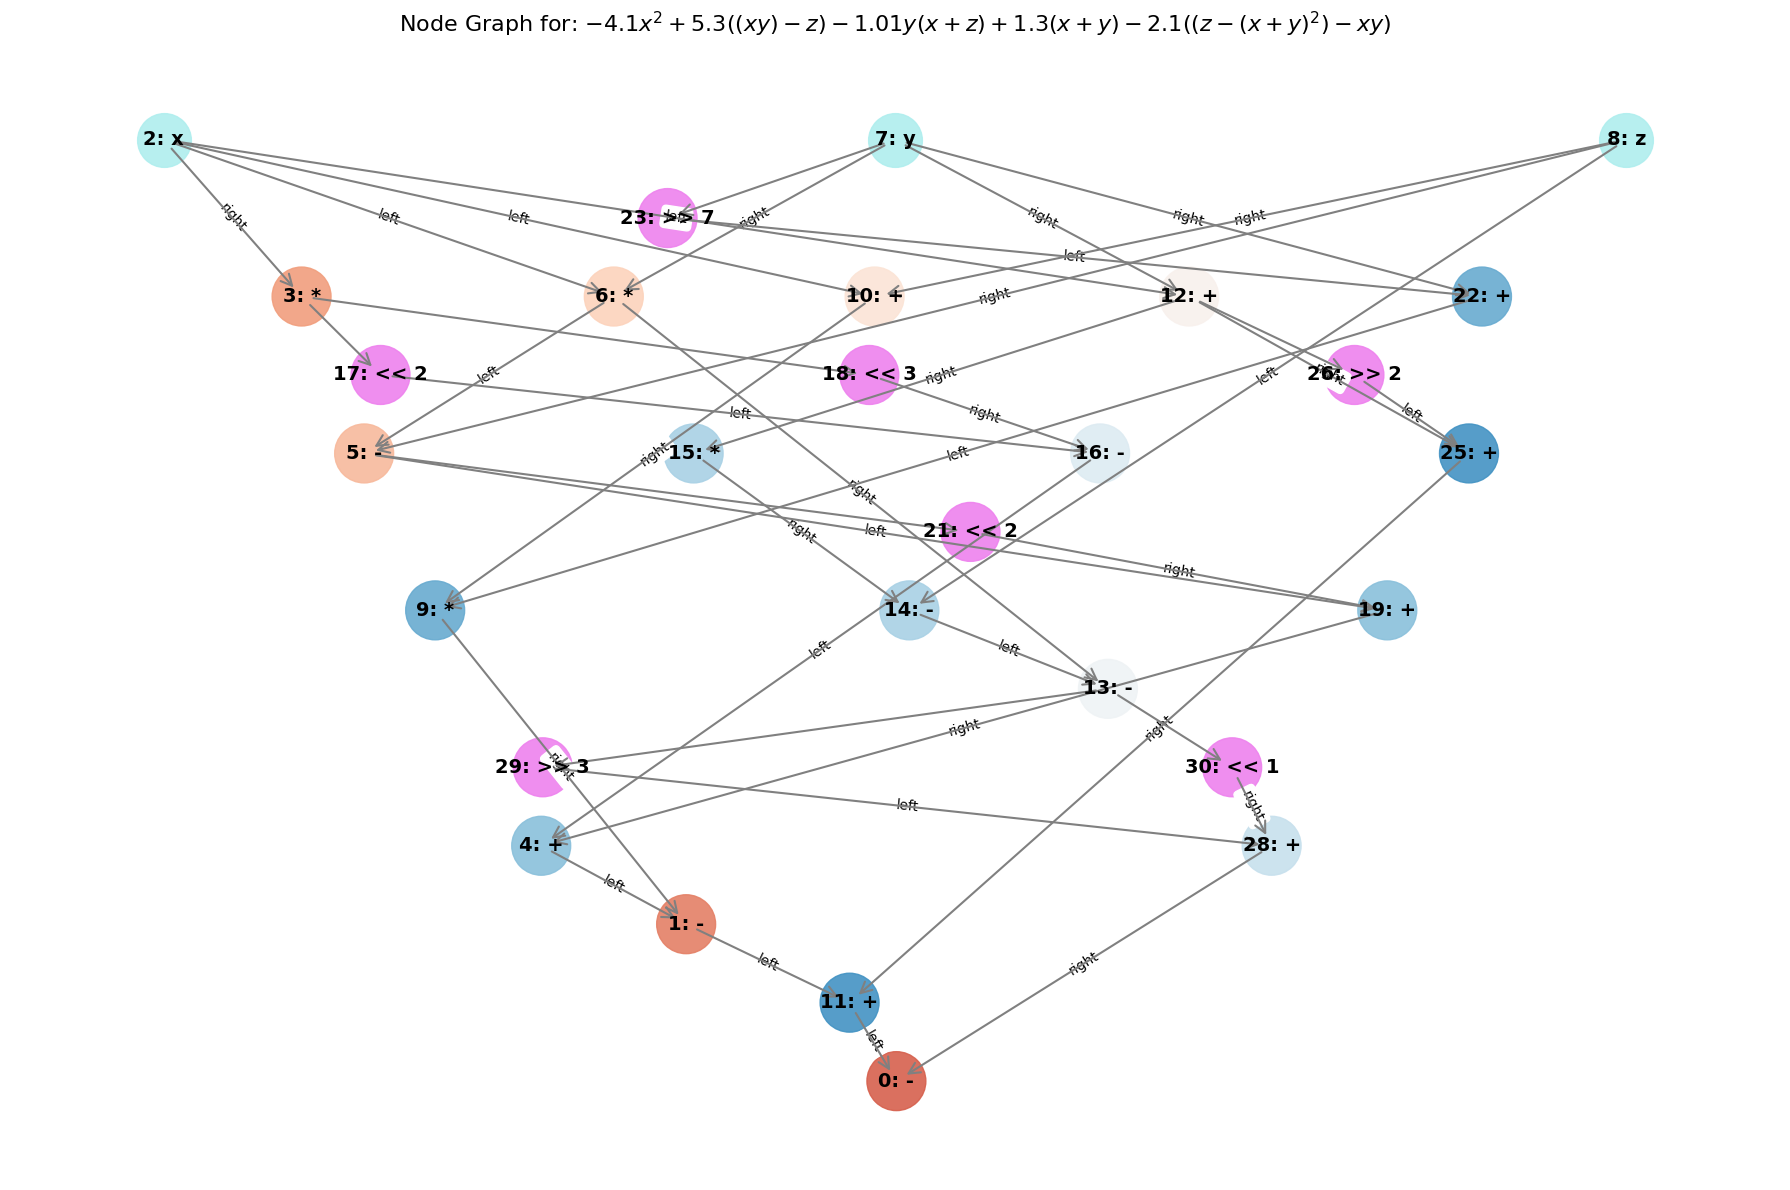

[[0], [1], [3], [5], [6], [10], [12], [13], [16], [28], [15, 14], [19, 4], [22, 9], [25, 11]]


In [226]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
from copy import deepcopy
from itertools import product
import pulp as pu
import re


class PolynomialTerm:
    def __hash__(self):
        return hash(str(self))
    
    def __str__(self):
        return str(self.value)
    
    def is_number(self):
        return False
        
    def is_symbol(self):
        return False
    
    def could_extract_minus_sign(self):
        return False


class Variable(PolynomialTerm):
    def __init__(self, value):
        self.value = value
        
    def is_symbol(self):
        return True


class Constant(PolynomialTerm):
    def __init__(self, value):
        self.value = float(value)
        
    def is_number(self):
        return True
        
    @property
    def is_integer(self):
        return self.value == int(self.value)
        
    def __gt__(self, second):
        if isinstance(second, Constant):
            return self.value > second.value
        return self.value > second
        
    def __eq__(self, second):
        if isinstance(second, Constant):
            return self.value == second.value
        return self.value == second
    
    def __hash__(self):
        return hash(self.value)


class BinaryOperation(PolynomialTerm):
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    @property
    def args(self):
        return [self.left, self.right]


class Addition(BinaryOperation):
    def __str__(self):
        return f"{self.left} + {self.right}"
    

class Subtraction(BinaryOperation):
    def __str__(self):
        return f"{self.left} - {self.right}"
    

class Multiplication(BinaryOperation):
    def __str__(self):
        # Add parentheses around additions and subtractions to preserve precedence
        left_str = str(self.left)
        right_str = str(self.right)

        if isinstance(self.left, (Addition, Subtraction)):
            left_str = f"({left_str})"
            
        if isinstance(self.right, (Addition, Subtraction)):
            right_str = f"({right_str})"
            
        return f"{left_str} * {right_str}"
    

class Power(BinaryOperation):
    def __str__(self):
        # Add parentheses around the base if needed
        left_str = str(self.left)
        if isinstance(self.left, (Addition, Subtraction, Multiplication)):
            left_str = f"({left_str})"
            
        return f"{left_str}^{self.right}"
    

class UnaryMinus(PolynomialTerm):
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        term_str = str(self.value)
        if isinstance(self.value, (Addition, Subtraction, Multiplication)):
            term_str = f"({term_str})"
        return f"-{term_str}"
    
    def is_number(self):
        return self.value.is_number() if hasattr(self.value, 'is_number') else False
    
    def could_extract_minus_sign(self):
        return True
    
    @property
    def args(self):
        return [self.value]


class PolynomialParser:
    def __init__(self, expr_string):
        self.expr_tree = None
        self.parse(expr_string)

    
    def parse(self, expr):
        self.expr = expr.replace(' ', '') 
        self.pos = 0
        self.expr_tree = self.parse_expression()
        return self
    
    def current_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos]
    
    def next_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos + 1] if self.pos + 1 < len(self.expr) else None

    
    def parse_expression(self):
        if self.current_char() == '-' and self.next_char() and not self.next_char().isdigit():
            self.pos += 1
            left = Multiplication(Constant(-1.0), self.parse_term())
        else:
            left = self.parse_term()
        
        while self.current_char() in ('+', '-'):
            op = self.current_char()
            self.pos += 1
            right = self.parse_term()
            
            if op == '+':
                left = Addition(left, right)
            else:
                left = Subtraction(left, right)
        
        return left
    
    def parse_term(self):
        left = self.parse_factor()
        
        while self.current_char() == '*':
            self.pos += 1
            right = self.parse_factor()
            left = Multiplication(left, right)
                
        return left
    
    def parse_factor(self):
        char = self.current_char()
        
        # End of expression check
        if char is None:
            return None
        
        #  unary minus
        if char == '-' and self.next_char() and not self.next_char().isdigit():
            self.pos += 1
            return UnaryMinus(self.parse_factor())
        
        # Brackets
        if char == '(':
            self.pos += 1
            expr = self.parse_expression()
            self.pos += 1  # Skip closing bracket
            
            if self.current_char() == '^':
                self.pos += 1
                exponent = self.parse_factor()
                return Power(expr, exponent)
                
            return expr
        
        #  numbers
        if char.isdigit() or (char == '-' and self.next_char() and self.next_char().isdigit()):
            return self.parse_number()
        
        #  variables
        if char.isalpha():
            var = self.parse_variable()
            
            # Check for power after variable
            if self.current_char() == '^':
                self.pos += 1
                exponent = self.parse_factor()
                return Power(var, exponent)

            return var
            
    
    def parse_number(self):
        start_pos = self.pos
        char = self.current_char()
        
        while char is not None and (char.isdigit() or char == '.' or char == '-'):
            self.pos += 1
            char = self.current_char()
        
        # Create constant
        value = float(self.expr[start_pos:self.pos])
        return Constant(value)
    
    def parse_variable(self):
        start_pos = self.pos
        char = self.current_char()
        
        while char is not None and char.isalnum():
            self.pos += 1
            char = self.current_char()
            
        variable = self.expr[start_pos:self.pos]
        return Variable(variable)


# -------------------------------------------------------------
# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):

    
    if expr_to_id is None:
        expr_to_id = {}
    
    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    #  Addition and Multiplication operations
    if isinstance(expr, (Addition, Multiplication)):
        args = list(expr.args)
        
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, Addition) else "*", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            
            # Process each term in the top-level expression
            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, add_node, top_level=False, expr_to_id=expr_to_id)
            
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            # Creates a binary tree for addition/multiplication
            if isinstance(expr, Addition,):
                label = "+"
            else:
                label = "*"
                
            if len(args) > 0:
                left_expr = args[0]
                node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
                for i in range(1, len(args)):
                    expr_branch = args[i]
                    
                    # if isinstance(expr, Addition) and expr_branch.could_extract_minus_sign():
                    #     # For addition with negative term, create a subtraction node instead
                    #     parent_node = node_id
                    #     graph.add_node(parent_node, label="-", type="operation")
                    #     expr_to_id[expr_hash] = parent_node
                    #     node_id += 1
                        
                    #     # Connect to the parent node if exists
                    #     if parent_id is not None:
                    #         graph.add_edge(parent_node, parent_id)
                    #         parent_id = parent_node
                        
                    #     # Left branch is the result so far
                    #     graph.add_edge(left_id, parent_node, label='left')
                        
                    #     # Right branch is the term without the negative sign
                    #     if isinstance(expr_branch, UnaryMinus):
                    #         term_without_minus = expr_branch.value
                    #     # else:
                    #     #     term_without_minus = expr_branch 
                            
                    #     node_id, right_id = process_expression(term_without_minus, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                    #     graph.add_edge(right_id, parent_node, label='right')
                    # else:
                        # Standard addition or multiplication node
                    parent_node = node_id
                    graph.add_node(parent_node, label=label, type="operation")
                    expr_to_id[expr_hash] = parent_node
                    node_id += 1
                    
                    # Connect to the parent node if exists
                    if parent_id is not None:
                        graph.add_edge(parent_node, parent_id)
                        parent_id = parent_node
                    
                    # Left branch is the result so far
                    graph.add_edge(left_id, parent_node, label='left')
                    
                    # Right branch is the current term
                    node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                    graph.add_edge(right_id, parent_node, label='right')
                    
                    left_id = parent_node  # for chaining operations
                
                return node_id, left_id


    # Power operation
    elif isinstance(expr, Power):
        base, exp = expr.args
        if hasattr(exp, 'is_integer') and exp.is_integer and exp > 1:
            return convert_power_to_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id)

            
    #  variables
    elif isinstance(expr, Variable) or hasattr(expr, 'is_symbol') and expr.is_symbol():
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    #  constants
    elif hasattr(expr, 'is_number') and expr.is_number():
        curr_id = node_id
        # Display negative numbers directly with the negative sign
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    #  unary minus
    elif isinstance(expr, UnaryMinus):
        curr_id = node_id
        graph.add_node(curr_id, label="-", type="operation")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        
        # Process the term inside the unary minus
        node_id, term_id = process_expression(expr.value, graph, node_id, curr_id, top_level=False, expr_to_id=expr_to_id)
        
        return node_id, curr_id
    
    #  subtraction
    elif isinstance(expr, Subtraction):
        sub_node = node_id
        graph.add_node(sub_node, label="-", type="operation")
        expr_to_id[expr_hash] = sub_node
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(sub_node, parent_id)
        
        # Process left and right terms
        node_id, left_id = process_expression(expr.left, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(left_id, sub_node, label='left')
        
        node_id, right_id = process_expression(expr.right, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(right_id, sub_node, label='right')
        
        return node_id, sub_node


def convert_power_to_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id):
    expr_hash = hash(expr)
    
    #  the base case of x^1 (just return the base itself)
    if exp == 1:
        return process_expression(base, graph, node_id, parent_id, top_level=False, expr_to_id=expr_to_id)
    
    # Special case for x^2: Create a multiplication node with two edges from the same x node
    if exp == 2:
        # First, process the base to get its node
        node_id, base_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
        # Create multiplication node
        mul_node = node_id
        graph.add_node(mul_node, label="*", type="operation")
        expr_to_id[expr_hash] = mul_node
        node_id += 1
        
        # Add two edges from the same base node to the multiplication node
        graph.add_edge(base_id, mul_node, label='left')
        graph.add_edge(base_id, mul_node, label='right')
        
        # Connect to parent if needed
        if parent_id is not None:
            graph.add_edge(mul_node, parent_id)
            
        return node_id, mul_node
    
    # For exponents > 2, create a binary tree of multiplications
    # For odd exponents: x^n = x * (x^(n-1))
    # For even exponents: x^n = (x^(n/2)) * (x^(n/2))
    if exp % 2 == 0:
        # For even exponents, create a balanced tree
        left_exp = exp // 2
        right_exp = exp // 2
    else:
        # For odd exponents it does x * (x^(n-1))
        left_exp = 1
        right_exp = exp - 1
    
    # Process left part
    if left_exp == 1:
        node_id, left_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        left_power_expr = base ** left_exp
        node_id, left_id = convert_power_to_multiplication(left_power_expr, base, left_exp, graph, node_id, None, expr_to_id)
    
    # Process right part
    if right_exp == 1:
        node_id, right_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        right_power_expr = base ** right_exp
        node_id, right_id = convert_power_to_multiplication(right_power_expr, base, right_exp, graph, node_id, None, expr_to_id)
    
    # Create multiplication node
    mul_node = node_id
    graph.add_node(mul_node, label="*", type="operation")
    expr_to_id[expr_hash] = mul_node
    node_id += 1
    
    # Connect the operands
    graph.add_edge(left_id, mul_node, label='left')
    graph.add_edge(right_id, mul_node, label='right')
    
    # Connect to parent if needed
    if parent_id is not None:
        graph.add_edge(mul_node, parent_id)
        
    return node_id, mul_node

# ------------------------------------------------------------------


class DisplayTree:

    def __init__(self, graph, polynomial_str, specific_node_colors = None, provided_levels = None):
        self.display_graph(graph, polynomial_str, specific_node_colors, provided_levels)


    def display_graph(self, graph, polynomial_str, specific_node_colors = None, provided_levels = None):
        
        if specific_node_colors is None:
            specific_node_colors = {}

        node_labels = nx.get_node_attributes(graph, 'label')
        if provided_levels is None:
            levels = self.stage_levels(graph)
            pos = self.custom_layout(levels)
        else:
            pos = self.custom_layout(provided_levels)

        #print(pos)
        
        plt.figure(figsize=(18, 12))
        
        #Divide up the nodes
        operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
        value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

        operation_node_colors = [specific_node_colors.get(node, 'violet') for node in operation_nodes]


        edges = nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
        for edge in edges:
            edge.set_zorder(2)
        
        nodes = nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color = operation_node_colors, alpha=0.9)
        nodes.set_zorder(1)

        nodes = nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)
        nodes.set_zorder(1)

        edge_labels = nx.get_edge_attributes(graph, 'label')

    # Draw edge labels
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        
        
        node_id_labels = {node: str(node) for node in graph.nodes()}
        #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
        # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
        
        labels = {}
        for node in graph.nodes():
            attr_value = graph.nodes[node].get('label', '')
            labels[node] = f"{node}: {attr_value}"
        
        graph_labels = nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')
        for text in graph_labels.values():
            text.set_zorder(3)  # labels on top


        plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show() 


    # Orders nodes based on stages starting from the symbolic characters
    def stage_levels(self, G):
        levels = {}
        topo_order = list(nx.topological_sort(G))
        for node in topo_order:
            preds = list(G.predecessors(node))
            if not preds:
                levels[node] = 0
            else:

                levels[node] = max(levels[p] + 1 for p in preds)

        
        for node in topo_order:
            preds = list(G.predecessors(node))
            if preds:
                labels = [G.nodes[s]['label'] for s in preds]
                shift_count = sum('<<' in label or '>>' in label for label in labels)
                pred_diff = max([levels[node] - levels[s] for s in preds])
                
                #print("Max diff:", pred_diff)

                if shift_count == 2 or (shift_count == 1 and all('<<' in label or '>>' in label or label.isalnum() for label in labels)) or (shift_count == 1 and pred_diff > 1):
                    levels[node] = levels[node] - 1

        return levels


    def organise_nodes_by_level(self, levels):
        nodes_by_level = {}
        
        for node, level in levels.items():
            if level not in nodes_by_level:
                nodes_by_level[level] = []
            nodes_by_level[level].append(node)

        return {k: v for k, v in sorted(nodes_by_level.items())}

    def custom_layout(self, levels):
        pos = {}
        
        #levels = self.stage_levels(G)
        nodes_by_level = self.organise_nodes_by_level(levels)
        
        # for level in nodes_by_level:
        #     nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
        
        max_level = max(nodes_by_level)
        spacing = 1
        
        for level, nodes in nodes_by_level.items():
            num_nodes = len(nodes)
            #print("Number of nodes: ", num_nodes)
            
            if level == 0:
                max_span = (num_nodes - 1) * spacing   
                #print("Max span: ", max_span) 
                x_start = -max_span / 2
                for i, node in enumerate(sorted(nodes)):
                    x = x_start + i * spacing
                    y = max_level - level
                    pos[node] = (x, y)
                    
            else:
                if(num_nodes == 1):
                    x_start =  random.uniform(-0.2 * max_span, 0.2 * max_span)
                else:
                    span = (num_nodes - 1) * (max_span/num_nodes)
                    x_start = - span / 2
                    
                for i, node in enumerate(sorted(nodes)):
                    x = x_start + i * (max_span/num_nodes) + random.uniform(-0.02 * max_span, 0.02 * max_span)
                    y = max_level - level
                    pos[node] = (x, y)     
        
        return pos
    
    

class DSPSolver:
    def __init__(self, graph):
        self.original_graph = graph
        self.dsp_combos = self.generate_valid_combinations()
        self.graph, self.BitShift_graph = self.remove_non_dsp_nodes(graph)

    def generate_valid_combinations(self):
        operations = ['+', '-', '*']
        combos_by_length = []

        for length in range(1, 4):
            for combo in product(operations, repeat=length):
                combo = tuple(combo)

                if length == 1:
                    combos_by_length.append(combo)

                elif length == 2:
                    if combo.count('*') <= 1:
                        combos_by_length.append(combo)

                elif length == 3:
                    if combo[1] == '*' and combo.count('*') == 1:
                        combos_by_length.append(combo)

        return combos_by_length

    def remove_non_dsp_nodes(self, G):
        G_new = deepcopy(G)
        remove_nodes = []

        for node in G_new.nodes():
            label = G_new.nodes[node]['label']
            if label.isalnum() or "<<" in label or ">>" in label:
                remove_nodes.append(node)

        for node in remove_nodes:
            G_new.remove_node(node)

        return G_new, G


    def graph_operation_combos(self, G, G_with_bitshifts, dsp_combos):
        possible_combos = []

        for node in G.nodes():
            val = G.nodes[node]['label']
            if (val,) in dsp_combos:
                possible_combos.append([node])

        # Multi node patterns
        for node in G.nodes():
            visited_nodes = []
            queue = deque([(node, [node])])

            while queue:
                current, path = queue.popleft()

                if tuple(path) in visited_nodes:
                    continue
                visited_nodes.append(tuple(path))

                if len(path) > 1:
                    sub_graph = G.subgraph(path)

                    # Check that graph is connected
                    if not nx.is_weakly_connected(sub_graph):
                        continue

                    operations = tuple([G.nodes[n]['label'] for n in path])

                    if operations in dsp_combos:
                        added = False

                        for m in range(len(operations)):
                            if operations[m] == '-' and m > 0:
                                added = True
                                edge = list(G.in_edges(path[m], data=True))
                                if path[m-1] == edge[0][0] and path[m] == edge[0][1] and edge[0][2]['label'] == 'right':
                                    possible_combos.append(path)

                        if not added:
                            possible_combos.append(path)

                if len(path) > 3:
                    continue

                neighbours = list(G.successors(current))
                for k in neighbours:
                    if k not in path:
                        queue.append((k, path + [k]))

        # Checks for duplicates
        unique_possible_combos = []
        seen = []

        for j in possible_combos:
            if j not in seen:
                seen.append(j)
                unique_possible_combos.append(j)


        # print("List: ", unique_possible_combos)

        final_possible_combos = []

        # Needed because two nodes in a DSP block cannot have a bit shift between them
        for each_item in unique_possible_combos:
            # print("Item: ", each_item)
            if len(each_item) > 1:
                 for node in each_item:
                    # print(node)

                    two_nodes_ago = []
                     
                     
                    #print("Grandparent of node: ", circle)
                    parent = list(G_with_bitshifts.predecessors(node))
                    #print("Parents of node: ", parent)

                    if parent:
                        for w in parent:
                            grandparent = list(G_with_bitshifts.predecessors(w))

                            for item in grandparent:

                                two_nodes_ago.append(item)
                    
                     
                    # print(two_nodes_ago)
            #         # two_nodes_ago_right = list(G.predecessors(list(G.predecessors(node))[1]))
            #         # two_nodes_ago.append(two_nodes_ago_left)
            #         # two_nodes_ago.append(two_nodes_ago_right)
                    # print("Grandparents: ", node, two_nodes_ago)

                    if two_nodes_ago:
                        # Returns true if two predecessors of the node is in the same DSP block
                        # These combos are not possible
                        # print(each_item)
                        shift_between_nodes = [two_nodes_ago[s] in each_item for s in range(0, len(two_nodes_ago))]
                        #print(shift_between_nodes)
                        # print(shift_between_nodes)
                        if shift_between_nodes:
                            # print(shift_between_nodes)
                            if not any(shift_between_nodes):
                                # print("all false")
                                # print(shift_between_nodes)
                                if each_item not in final_possible_combos:
                                    final_possible_combos.append(each_item)
                                continue

                            elif each_item in final_possible_combos:
                                final_possible_combos.remove(each_item)
                                continue
                        
                        # print("Final Combos: ", final_possible_combos)
            else:
                final_possible_combos.append(each_item)
        
        print(final_possible_combos)

        return final_possible_combos


    def disjoint(self, list1, list2):
        return not any(item in list2 for item in list1)

    def GreedySolver(self):
        specific_combos = self.graph_operation_combos(self.graph, self.BitShift_graph, self.dsp_combos)
        
        
        valid_combos = []

        for combo in specific_combos:
            if len(combo) < 2:
                valid_combos.append(combo)
            else:
                valid_combo = True
                non_last_nodes = combo[:-1]

                for node in non_last_nodes:
                    children = list(self.graph.successors(node))
                    if len(children) > 1:
                        valid_combo = False
                        break

                if valid_combo:
                    valid_combos.append(combo)
            

        universe = set(self.graph.nodes())
        covered = set()
        solutions = []

        while universe:
            best_combo = None
            most_nodes = 0

            for combo in valid_combos:
                if not self.disjoint(combo, covered):
                    continue

                if len(combo) > most_nodes:
                    best_combo = combo
                    most_nodes = len(combo)


            solutions.append(best_combo)
            covered.update(best_combo)
            universe -= set(best_combo)

        return solutions

    @property
    def Solver(self):
        specific_combos = self.graph_operation_combos(self.graph, self.BitShift_graph, self.dsp_combos)

        problem = pu.LpProblem("DSPSolver", sense=pu.LpMinimize)
        binary_dsp_combos = {}

        for i, combo in enumerate(specific_combos):
            binary_dsp_combos[i] = pu.LpVariable(f"combo_{i}", cat = 'Binary')

        # Goal
        problem += pu.lpSum(binary_dsp_combos.values())

        # Define constraint
        for node in self.graph.nodes():

            combos_with_node = []
            for i, combo in enumerate(specific_combos):
                if node in combo:
                    combos_with_node.append(i)

            problem += pu.lpSum(binary_dsp_combos[k] for k in combos_with_node) == 1

        # Additional constraint
        # if a group of nodes is chosen with more than one node in the group, then only the last node in that group can point to more than one child
        for i, combo, in enumerate(specific_combos):
            if len(combo) > 1:
                non_last_nodes = combo[:-1]
                invalid_combo = False

                for node in non_last_nodes:
                    children = list(self.graph.successors(node))
                    if len(children) > 1:
                        invalid_combo = True
                        break

                if invalid_combo:
                    problem += binary_dsp_combos[i] == 0

        solver = pu.PULP_CBC_CMD(timeLimit=5)
        # Stops after finding one solution
        result = problem.solve(solver)

        if pu.LpStatus[result] != 'Optimal':
            print("No optimal")
            return self.GreedySolver()
        
        
        ilp_solutions = []
        for j, combo in binary_dsp_combos.items():
            if combo.value() == 1:
                    ilp_solutions.append(specific_combos[j])

        return ilp_solutions



def check_numeric(s):
    s = s.strip()
    try:
        float(s)
        return True
    except ValueError:
        return False


def merge_negatives(G):
    G_mod = deepcopy(G)
    nodes_to_remove = []

    new_node = []
    new_edges = []

    for node in list(G_mod.nodes()):
        if G_mod.nodes[node].get('label') == '*':
            parent_edges = list(G_mod.in_edges(node, data=True))
            
            if len(parent_edges) > 1:
                parent1, parent2 = parent_edges[0][0], parent_edges[1][0]
                
                if (G_mod.nodes[parent1].get('type') == 'value' and 
                    G_mod.nodes[parent2].get('type') == 'value' and
                    check_numeric(G_mod.nodes[parent1].get('label', '')) and 
                    check_numeric(G_mod.nodes[parent2].get('label', ''))):
                    
                    # Calculate new value
                    new_value = (float(G_mod.nodes[parent1]['label']) * float(G_mod.nodes[parent2]['label']))
                    
                    children_edges = list(G_mod.out_edges(node, data=True))
                    nodes_to_remove.append(node)
                    nodes_to_remove.append(parent1)
                    nodes_to_remove.append(parent2)


                    new_node.append(((node, {'label': str(new_value)})))
                    new_edges.append(children_edges[0])

    # Apply all changes

    for i in nodes_to_remove:
        # Remove all edges connected to the node
        G_mod.remove_edges_from(list(G.in_edges(i)))  # Remove incoming edges
        G_mod.remove_edges_from(list(G.out_edges(i)))  # Remove outgoing edges
        
        # Remove the node itself
        G_mod.remove_node(i)



    for i in new_node:
        G_mod.add_node(i[0], label= i[1]['label'], type="value")

    for j in new_edges:
        G_mod.add_edge(j[0], j[1], label = j[2]['label'])


    G_relabelled = relabel_graph(G_mod)
        

    return G_relabelled


def relabel_graph(G):
    old_nodes = sorted(G.nodes())
    new_labels = {old: new for new, old in enumerate(old_nodes)}

    # Relabel nodes
    G_relabelled = nx.relabel_nodes(G, new_labels, copy=True)

    return G_relabelled


def implement_bit_shifts(G):

    remove_vals = [] # Remove the node with the value
    remove_nodes = []  # Contains the multiplocation node. Remove the nodes and its edges
    bit_shift_nodes = [] # Each sub list has the structure: [(... Bit shifts ... , operation), parent node, child node]

    for node in G.nodes():
        if G.nodes[node].get('label', '') == '*' and len(G.in_edges(node)) == 2:
            #print(G.nodes[node])

            edges = list(G.in_edges(node, data = True))
            #print(edges)

            for i, tup in enumerate(edges):
                if(tup[2].get('label', '') == 'left'):
                    left_edge = tup
                else:
                    right_edge = tup

            # If the left edge is not a number, then continue with the loop
            if not check_numeric(G.nodes[left_edge[0]].get('label', '')):
                continue
            
            # print(node)
            val = G.nodes[left_edge[0]].get('label', '')
            best_combination, best_sum = closest_power_of_2(float(val))

            # print( "Node to remove: ", left_edge[0])
            remove_vals.append(left_edge[0]) # Adds the node that is the number

            # print("Multiplication node is: ", node)
            remove_nodes.append(node) # Adds multiplication node whos in edges will be removed
            parent_node = right_edge[0]
            child_node = list(G.out_edges(node))[0][1]
            # print("Parent node is: ", parent_node)
            # print("Child node is: ", child_node)

            bit_shift_nodes.append([best_combination, parent_node, child_node])


    max_id = max(G.nodes()) + 1
    for j, combo in enumerate(bit_shift_nodes):
        multiplication_node = remove_nodes[j] # Related multiplication node that needs to be deleted
        out_edge_label = list(G.out_edges(multiplication_node, data = True))[0][2].get('label', '') 

        node_operation = combo[0][2]

        G.add_node(max_id, label = node_operation, type = "operation")

        operator_id = max_id
        max_id += 1

        for i in [combo[0][0], combo[0][1]]:
            if i < 0:
                label = ">> " + str(abs(i))
            else:
                label = "<< " + str(abs(i))

            if i == combo[0][0]:
                edge_label = "left"
            else:
                edge_label = "right"

            G.add_node(max_id, label= label, type="operation")

            G.add_edge(combo[1], max_id)
            G.add_edge(max_id, operator_id, label = edge_label)
            max_id += 1

        G.add_edge(operator_id, combo[2], label = out_edge_label)

    G.remove_nodes_from(remove_vals)
    for item in remove_nodes:
        G.remove_node(item)

    G = relabel_graph(G)
    G = remove_0_bit_shifts(G)

    return G


def closest_power_of_2(coeff):
    best_sum = None
    closest_diff = float('inf')
    best_combination = None
    
    max_exp = 20 
    min_exp = -10  

    # Iterate through all possible pairs of powers of 2
    for exp1 in range(min_exp, max_exp + 1):
        for exp2 in range(min_exp, max_exp + 1):
            power1 = 2 ** exp1
            power2 = 2 ** exp2

            # # Single power 2^exp1
            # single_power = power1
            # diff_single = abs(coeff - single_power)
            # if diff_single < closest_diff:
            #     closest_diff = diff_single
            #     best_sum = single_power
            #     best_combination = (exp1)
            
            # Calculate sum (2^exp1 + 2^exp2)
            power_sum = power1 + power2
            diff_sum = abs(coeff - power_sum)
            if diff_sum < closest_diff:
                closest_diff = diff_sum
                best_sum = power_sum
                best_combination = (exp1, exp2, '+')

            # Calculate difference (|2^exp1 - 2^exp2|)
            power_diff = power1 - power2
            diff_diff = abs(coeff - power_diff)
            if diff_diff < closest_diff:
                closest_diff = diff_diff
                best_sum = power_diff
                best_combination = (exp1, exp2, '-')

    print(coeff, best_combination, best_sum)
    return best_combination, best_sum


def remove_0_bit_shifts(G):
    remove_nodes = []
    new_edge = []
    for node in G.nodes():
        if G.nodes[node]['label'] == "<< 0":
            #print(G.nodes[node]['label'])

            in_edge = list(G.in_edges(node))[0][0]
            out_edge = list(G.out_edges(node))[0][1]
            out_edge_label = list(G.out_edges(node, data = True))[0][2]['label']

            #print(node)
            remove_nodes.append(node)
            new_edge.append((in_edge, out_edge, out_edge_label))

    for item in remove_nodes:
        G.remove_node(item)
    
    for j in new_edge:
        G.add_edge(j[0], j[1], label = j[2])

    return G


def make_color_assignments(dsp_solutions):
    color_assignments = {}
    cmap = plt.get_cmap('RdBu')
    color_list = [cmap(i) for i in np.linspace(0.2, 0.8, len(dsp_solutions))]
    for m in range(0, len(dsp_solutions)):
        for j in dsp_solutions[m]:
            color_assignments[j] = color_list[m]

    return color_assignments



def construct_pipeline(G, initial_levels):
    new_levels = dict(initial_levels)

    unique_y = {y for y in new_levels.values()}
    unique_y = sorted(list(unique_y)) 

    #m = max(unique_y)
    m = 0
    count = max(unique_y)
    while count >= 0:
        print(count, m)
        same_level_nodes = [key for key, y in new_levels.items() if y == m]
        print(same_level_nodes)
        #print(same_level_nodes)
        nodes_to_exclude = []
        for k in same_level_nodes:
            node_label = G.nodes[k]['label']
            if re.search(r'<<|>>', node_label):
                nodes_to_exclude.append(k)

        print(nodes_to_exclude)

        if nodes_to_exclude:
            for key, y in new_levels.items():
                print(key, y)
                if key not in nodes_to_exclude and y >= m:
                    new_levels[key] = y + 1  

                # else:
                #     new_levels[key] = y

            m += 2
        else:
            m += 1

        unique_y = {y for y in new_levels.values()} 
        unique_y = sorted(list(unique_y))

        count -= 1

    return new_levels



#user_input = input("\nEnter a polynomial: ")
user_input = "(x*y*z)^2 -1.2*(x+z)^2*y*(y- 1.3*x) - 7.8*(x - 6.1*z) + 5*((x + y) - x)"
user_input = "x^2 + (z - x*y)"
# user_input = "-2.5*(x+z)^2 + (z - x*y) + (z*x - y) "
user_input = "-4.1*x^2 + 5.3*((x*y) - z) - 1.01*y*(x+z) + 1.3*(x+ y) - 2.1*(( z - (x+y)^2) - x*y)"
# user_input = "1.5*x^2 + 1.6*(3.2*z - x*y )"
#user_input = "(((6.4*(x - (z^2) - 3.5*z)^2)^2) - 2.1*y^2" ### Generates an error
#user_input = "x^2 + y + z"

# if user_input.strip():
#user_input = user_input.replace('^', '**')



poly = PolynomialParser(user_input)
G = nx.DiGraph()
node_id, root_id = process_expression(poly.expr_tree, G, 0)

DisplayTree(G, user_input)

#G_mod = merge_negatives(G)
G_mod = implement_bit_shifts(G)
DisplayTree(G_mod, user_input)



DSPSearch = DSPSolver(G_mod)
dsp_combos = DSPSearch.Solver
print("Number of DSP Blocks: ", len(DSPSearch.Solver))

# Displays tree and assigns pos to the variable
initial_levels = DisplayTree(G_mod, user_input, specific_node_colors= make_color_assignments(DSPSearch.Solver)).stage_levels(G_mod)
print(initial_levels)
new_levels = construct_pipeline(G_mod, initial_levels)
print(new_levels)


DisplayTree(G_mod, user_input, specific_node_colors= make_color_assignments(DSPSearch.Solver), provided_levels = new_levels)

print(dsp_combos)

### Precision assessment

In [227]:
import numpy as np
import fixedpoint as fp
import matplotlib.pyplot as plt
import operator

def end_dsp_block(node, dsp_combos):

    for combo in dsp_combos:
        last_node = combo[-1]
        
        if node == last_node:
            return True
    
    return False



def last_node_in_dsp(G, node, dsp_combos):
    for combo in dsp_combos:
        operations = [G.nodes[s]['label'] for s in combo]
        if '*' in operations:
            
            #print(operations)
            if node == combo[-1]:
                print("End of DSP with mult")
                return True
        
    return False


def mult_postadder_use(G, node, dsp_combos):
    print(dsp_combos)
    for combo in dsp_combos:
        if len(combo) > 1:
            if last_node_in_dsp(G, node, dsp_combos) and G.nodes[combo[-2]]['label'] == '*':
                print('End of DSP Block with multiplier and poastadder')
                # print(G.nodes[combo[-2]]['label'])
                # print(combo[-1])
                # if G.nodes[combo[-2]]['label'] == '*' and node == combo[-1]:

                return True
    
    return False



print(mult_postadder_use(G_mod, 15, dsp_combos))

def twos_complement_to_int(val_str):
    val = int(val_str, 2)
    bits = len(val_str)
    if (val & (1 << (bits - 1))) != 0: 
        val = val - (1 << bits)        
    return val                        

def int_to_twos_complement(num, bits):
    if num >= 0:
        return bin(num)[2:].zfill(bits)
    return bin((1 << bits) + num)[2:]

def dsp_mult(a, b):
    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    product = a_int * b_int

    product_bin = int_to_twos_complement(product, len(a) + len(b))
    print(len(product_bin))

    if len(product_bin) < 43:
        sign_bit = product_bin[0]
        pad_len = 43 - len(product_bin)
        product_bin = (sign_bit * pad_len) + product_bin

    if len(product_bin) >= 43:
        final_product = product_bin[:43]
    else:
        final_product = product_bin

    return final_product

def dsp_add(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    sum = a_int + b_int
    sum_bin = int_to_twos_complement(sum, max(len(a), len(b)) + 1)

    return sum_bin

def dsp_subtract(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    diff = a_int - b_int
    diff_bin = int_to_twos_complement(diff, max(len(a), len(b)) + 1)

    return diff_bin


def arithmetic_shift(val_str, shifts):
    val = twos_complement_to_int(val_str)

    if shifts > 0:
        shifted = val << shifts
    elif shifts < 0:
        shifted = val >> -shifts

    shifted_bin = int_to_twos_complement(shifted, len(val_str))

    if shifted_bin[0] =='b':
        shifted_bin = shifted_bin[1:]
    
    return shifted_bin


# Starting nodes
print(new_levels)



converted_node_results = {}

def initial_values(new_levels, quantised):

    if quantised:

        values = ["00100000000000", "00110000000000", "01000000000000"]
    else:
        values = [2, 3, 4]


    node_results = {}

    starting_nodes = [node for node, level in new_levels.items() if level == 0]

    print("Starting nodes: ", starting_nodes)    

    vars = dict(zip(starting_nodes, values))

    for n in starting_nodes:
        node_results[n] = vars[n]

    return node_results



def calculate_expression(G, new_levels, quantised = False, m = 10, n = 10):

    ops = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul
    }
    
    node_results = initial_values(new_levels, quantised)

    if quantised:
        number_node_results = initial_values(new_levels, quantised = False)
    else:
        number_node_results = {}
    print(number_node_results)

    # First part is using the graph to compute a result with floating point


    for th in range(1, max(new_levels.values()) + 1):
        
        th_level = [node for node, level in new_levels.items() if level == th]

        for item in th_level:
            print("Node: ", item)
            truncate_multiplication = False

            preds = list(G.predecessors(item))

            operation = G.nodes[item]['label']

            print("operation: ", operation)


            if operation in ('+', '-', '*'):

                right = [u for u, v, attr in G.in_edges(item, data=True) if attr['label'] == 'right']
                left = [u for u, v, attr in G.in_edges(item, data=True) if attr['label'] == 'left']
            
                if operation == '*' and len(preds) == 1:

                    if quantised:
                        calculation = dsp_mult(node_results[preds[0]], node_results[preds[0]])
                        number_calculation = number_node_results[preds[0]]**2

                        if last_node_in_dsp(G_mod, item, dsp_combos):
                            truncate_multiplication = True
                        
                        #calculation = fp.FixedPoint(node_results[preds[0]]**2, signed = True, m = m, n = n, str_base = 2)
                    else:
                        calculation = node_results[preds[0]]**2


                    print("Calculation power: ", calculation)

                else:

                    left_value = node_results[left[0]]
                    right_value = node_results[right[0]]

                    print(left_value, right_value)

                    if quantised:
                        if operation == '*':
                            calculation = dsp_mult(left_value, right_value)
                        elif operation =='+':

                            if mult_postadder_use(G_mod, item, dsp_combos):
                                print("here")
                                print(left_value)
                                left_value = left_value.ljust(len(left_value) + 10, '0')
                                print("Extended left: ", left_value)

                            calculation = dsp_add(left_value, right_value)

                        elif operation == '-':
                            if mult_postadder_use(G_mod, item, dsp_combos):
                                print("here")
                                print(left_value)
                                left_value = left_value.ljust(len(left_value) + 10, '0')
                                print("Extended left: ", left_value)

                            calculation = dsp_subtract(left_value, right_value)
                        #calculation = fp.FixedPoint(ops[operation](left_value, right_value), signed = True, m = m, n = n, str_base = 2)
                        
                        #End of DSP block with a multiplier, truncate 2n frac bits
                        if last_node_in_dsp(G_mod, item, dsp_combos):
                            truncate_multiplication = True

                        left_value = number_node_results[left[0]]
                        right_value = number_node_results[right[0]]
                        number_calculation = ops[operation](left_value, right_value)
                    else:
                        calculation = ops[operation](left_value, right_value)

                    print(calculation)

            elif '<<' in operation or'>>' in operation:
                match = re.search(r'(<<|>>)\s*(\d+)', operation)
                direction, exponent = match.groups()

                if direction == '>>':
                    exponent = - int(exponent)

                else:
                    exponent = int(exponent)
                
                if quantised:
                    print("To shift: ", node_results[preds[0]])
                    calculation = arithmetic_shift(node_results[preds[0]], exponent)
                    # q_val = fp.FixedPoint(node_results[preds[0]], signed = True, m = m, n = n, str_base = 2)
                    # q_shifted = q_val << exponent
                    # calculation = fp.FixedPoint(q_shifted, signed = True, m = m, n = n, str_base = 2)
                    # print(float(q_val))
                    # print(q_val)

                    number_calculation = number_node_results[preds[0]] * (2 ** exponent)


                else:
                    calculation = node_results[preds[0]] * (2 ** exponent)

                print(calculation)

            
            if quantised:
                if truncate_multiplication:
                    # Multiplication was used meaning that 2n fractional bits have to be cut down to n fractional bits
                    print("We need to truncate here")
                    print(calculation[:-10])
                    calculation = calculation[:-10]

            

            
            if quantised:
                node_results[item] = str(calculation)

                number_node_results[item] = float(number_calculation)
            else:
                print(float(calculation))
                node_results[item] = float(calculation)

            if quantised:
                for u,v in node_results.items():
                    converted_node_results[item] = float(fp.FixedPoint("0b" + str(v), signed = True, m = len(v) - 10, n = 10, str_base = 2))

            print(node_results)
            print(converted_node_results)
            print(number_node_results)

    print(node_results[0])

    if quantised:
        v = node_results[0]
        print(float(fp.FixedPoint("0b" + str(v), signed = True, m = len(v) - 10, n = 10, str_base = 2)))


calculate_expression(G_mod, new_levels, quantised = True, m = 10, n = 2)

## Next step is to do the same calculation but the fixed point arithmetic

x = np.array([2])
y = np.array([3])
z = np.array([4])
result = eval(user_input.replace('^', '**'))      
print("Numpy calculation: ", result[0])



[[0], [1], [3], [5], [6], [10], [12], [13], [16], [28], [15, 14], [19, 4], [22, 9], [25, 11]]
False
{2: 0, 7: 0, 8: 0, 3: 2, 6: 2, 12: 2, 23: 1, 10: 2, 17: 3, 18: 3, 5: 4, 15: 4, 26: 3, 22: 2, 16: 4, 21: 5, 14: 6, 25: 4, 9: 6, 19: 6, 13: 7, 4: 9, 29: 8, 30: 8, 1: 10, 28: 9, 11: 11, 0: 12}
Starting nodes:  [2, 7, 8]
Starting nodes:  [2, 7, 8]
{2: 2, 7: 3, 8: 4}
Node:  23
operation:  >> 7
To shift:  00110000000000
00000000011000
{2: '00100000000000', 7: '00110000000000', 8: '01000000000000', 23: '00000000011000'}
{23: 0.0234375}
{2: 2, 7: 3, 8: 4, 23: 0.0234375}
Node:  3
operation:  *
28
End of DSP with mult
Calculation power:  0000000000000000000010000000000000000000000
We need to truncate here
000000000000000000001000000000000
{2: '00100000000000', 7: '00110000000000', 8: '01000000000000', 23: '00000000011000', 3: '000000000000000000001000000000000'}
{23: 0.0234375, 3: 4.0}
{2: 2, 7: 3, 8: 4, 23: 0.0234375, 3: 4.0}
Node:  6
operation:  *
00100000000000 00110000000000
28
End of DSP with

In [228]:
import fixedpoint as fp

# Apply truncation: rounding='down'
a = fp.FixedPoint(12.11234, signed = True, m = 5, n = 3, str_base = 2)
b = fp.FixedPoint(10.13243, signed = True, m = 5, n = 3, str_base = 2)

print(float(a), float(b))
c = float(a)*float(b)
print(float(c))
print(a.qformat)
print(12.11234 * 10.13243)
print(float(a) * float(b))
print(str(a))

x = fp.FixedPoint(c, signed = True, m = 4, n = 3, rounding = "down", overflow = "clamp", overflow_alert= 'ignore')

print(float(x))



# Beginning value is specified to a length of bits
# Operation inside DSP node is done with the maximum width that a DSP block can handle
# After last DSP node, result is truncated (rounding = down) to set Qm.n format
ops = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul
}


print("starting here")
a = fp.FixedPoint(4.23, signed = True, m = 5, n = 5, str_base = 2)
b = fp.FixedPoint(3.69, signed = True, m = 5, n = 5, str_base = 2)
print(float(a), float(b))

c = fp.FixedPoint(float(a) + float(b), signed = True, m = 6, n = 3, str_base = 2, rounding = "down")
print(str(c))
c = fp.FixedPoint(ops['+'](float(a), float(b)), signed = True, m = 6, n = 3, str_base = 2, rounding = "down")

print(str(c))
c_trunc = fp.FixedPoint(float(c), signed = True, m = 6, n = 0, str_base = 2, rounding = "down")
print(str(c_trunc))
print("Accurate: ", float(4.23 + 3.69))
print(float(c))


d = fp.FixedPoint(-4.23, signed=True, m=10, n=5, str_base = 2)
print("Original:", float(d), str(d))

# Step 2: Shift right by 3 bits (equivalent to dividing by 8)
d_shifted = d >> 3  # or d << -3
print("Shifted :", float(d_shifted), str(d_shifted))

# Step 3: Convert to Q10.5 explicitly
d_truncated = fp.FixedPoint(d_shifted, signed=True, m=10, n=5, rounding='trunc', overflow='clamp')
print("Final   :", float(d_truncated), str(d_truncated))




print(end_dsp_block(11, dsp_combos))



12.125 10.125
122.765625
Q5.3
122.72743718619999
122.765625
01100001
7.875
starting here
4.21875 3.6875
000111111
000111111
000111
Accurate:  7.92
7.875
Original: -4.21875 111111101111001
Shifted : -0.53125 111111111101111
Final   : -0.53125 111111111101111
True


In [229]:
def twos_complement_to_int(val_str):
    val = int(val_str, 2)
    bits = len(val_str)
    if (val & (1 << (bits - 1))) != 0: 
        val = val - (1 << bits)        
    return val                        

def int_to_twos_complement(num, bits):
    if num >= 0:
        return bin(num)[2:].zfill(bits)
    return bin((1 << bits) + num)[2:]


def arithmetic_shift(val_str, shifts):
    val = twos_complement_to_int(val_str)

    if shifts > 0:
        shifted = val << shifts
    elif shifts < 0:
        shifted = val >> -shifts

    shifted_bin = int_to_twos_complement(shifted, len(val_str))

    if shifted_bin[0] =='b':
        shifted_bin = shifted_bin[1:]
    
    return shifted_bin


def dsp_mult(a, b):
    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    product = a_int * b_int

    product_bin = int_to_twos_complement(product, len(a) + len(b))
    print(len(product_bin))
    # Extend to 24 bits
    if len(product_bin) < 43:
        sign_bit = product_bin[0]
        pad_len = 43 - len(product_bin)
        product_bin = (sign_bit * pad_len) + product_bin

    if len(product_bin) >= 43:
        msb24 = product_bin[:43]
    else:
        msb24 = product_bin

    return msb24

def dsp_add(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    sum = a_int + b_int
    sum_bin = int_to_twos_complement(sum, max(len(a), len(b)) + 1)

    return sum_bin

def dsp_subtract(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    diff = a_int - b_int
    diff_bin = int_to_twos_complement(diff, max(len(a), len(b)) + 1)

    return diff_bin




a = "0001101101010101000" 
b = "0100101010101010000011" 
n = 4
print(len(a), len(b))

a_float = float(fp.FixedPoint("0b" + str(a), signed = True, m = len(a) - n, n = n))
b_float = float(fp.FixedPoint("0b" + str(b), signed = True, m = len(b) - n, n = n))

print( float(fp.FixedPoint("0b" + str(a), signed = True, m = len(a) - n, n = n)))
print( float(fp.FixedPoint("0b" + str(b), signed = True, m = len(b) - n, n = n)))


msb24 = dsp_mult(a, b) 
print(f"Product: {msb24}")
print(a_float * b_float)
print( float(fp.FixedPoint("0b" + str(msb24), signed = True, m = 43 - 2*n, n = 2*n)))
dsp_add(a, b)
print("Addition: ", float(fp.FixedPoint("0b" + str(dsp_add(a, b)), signed = True, m = max(len(a), len(b)) + 1 - n, n = n )))
print(a_float + b_float)


dsp_subtract(a, b)
print("Subtraction: ", float(fp.FixedPoint("0b" + str(dsp_subtract(a, b)), signed = True, m = max(len(a), len(b)) + 1 - n, n = n)))
print(a_float - b_float)

shifted = arithmetic_shift(b, -8)
print(shifted)
print(len(shifted))
print("Subtraction: ", float(fp.FixedPoint("0b" + str(shifted), signed = True, m = len(b) - n, n = n)))


19 22
3498.5
76456.1875
41
Product: 0000000111111110001011100110111001111111000
267481971.96875
267481971.96875
Addition:  79954.6875
79954.6875
Subtraction:  -72957.6875
-72957.6875
0000000001001010101010
22
Subtraction:  298.625


#### Grouping DSP Nodes Together

In [230]:

dsp_blocks = DSPSearch.Solver
print(dsp_blocks)
print(new_levels)


def only_bitshifts(G, new_levels, level):
    for j in level:
        nodes_in_that_level = [w for w, v in new_levels.items() if v == j]
        labels = [G.nodes[s]['label'] for s in nodes_in_that_level]

        if not all(('<<' in s or '>>' in s) for s in labels):
            return False
        
    return True



def move_dsp_components(G, new_levels, dsp_combo):
    print(j)




for j in dsp_blocks:
    if len(j) > 1:
        print(j)

        related_levels = sorted([new_levels[i] for i in j])

        print("Levels of DSP components: ", related_levels)

        nodes_between_dsp_components = []

        levels_to_check = []
        for k in range(min(related_levels) + 1, max(related_levels)):
            if k in related_levels:
                continue

            levels_to_check.append(k)

            # nodes_in_that_level = [w for w, v in new_levels.items() if v == k]

            # nodes_between_dsp_components.extend(nodes_in_that_level)

            # #print(nodes_in_that_level)

            # #print(nodes_between_dsp_components)

            # #print(k)
        

        print(levels_to_check)

        if not only_bitshifts(G_mod, new_levels, levels_to_check):
            print("not only bit shifts")
            move_dsp_components(G_mod, new_levels, j)






    


[[0], [1], [3], [4], [5], [6], [9], [10], [11], [12], [13], [14], [15], [16], [19], [22], [25], [28], [1, 11], [6, 13], [10, 9], [12, 15], [15, 14], [16, 4], [19, 4], [22, 9], [25, 11]]
[[0], [1], [3], [5], [6], [10], [12], [13], [16], [28], [15, 14], [19, 4], [22, 9], [25, 11]]
{2: 0, 7: 0, 8: 0, 3: 2, 6: 2, 12: 2, 23: 1, 10: 2, 17: 3, 18: 3, 5: 4, 15: 4, 26: 3, 22: 2, 16: 4, 21: 5, 14: 6, 25: 4, 9: 6, 19: 6, 13: 7, 4: 9, 29: 8, 30: 8, 1: 10, 28: 9, 11: 11, 0: 12}
[15, 14]
Levels of DSP components:  [4, 6]
[5]
[19, 4]
Levels of DSP components:  [6, 9]
[7, 8]
not only bit shifts
[19, 4]
[22, 9]
Levels of DSP components:  [2, 6]
[3, 4, 5]
not only bit shifts
[22, 9]
[25, 11]
Levels of DSP components:  [4, 11]
[5, 6, 7, 8, 9, 10]
not only bit shifts
[25, 11]


# Extra Code

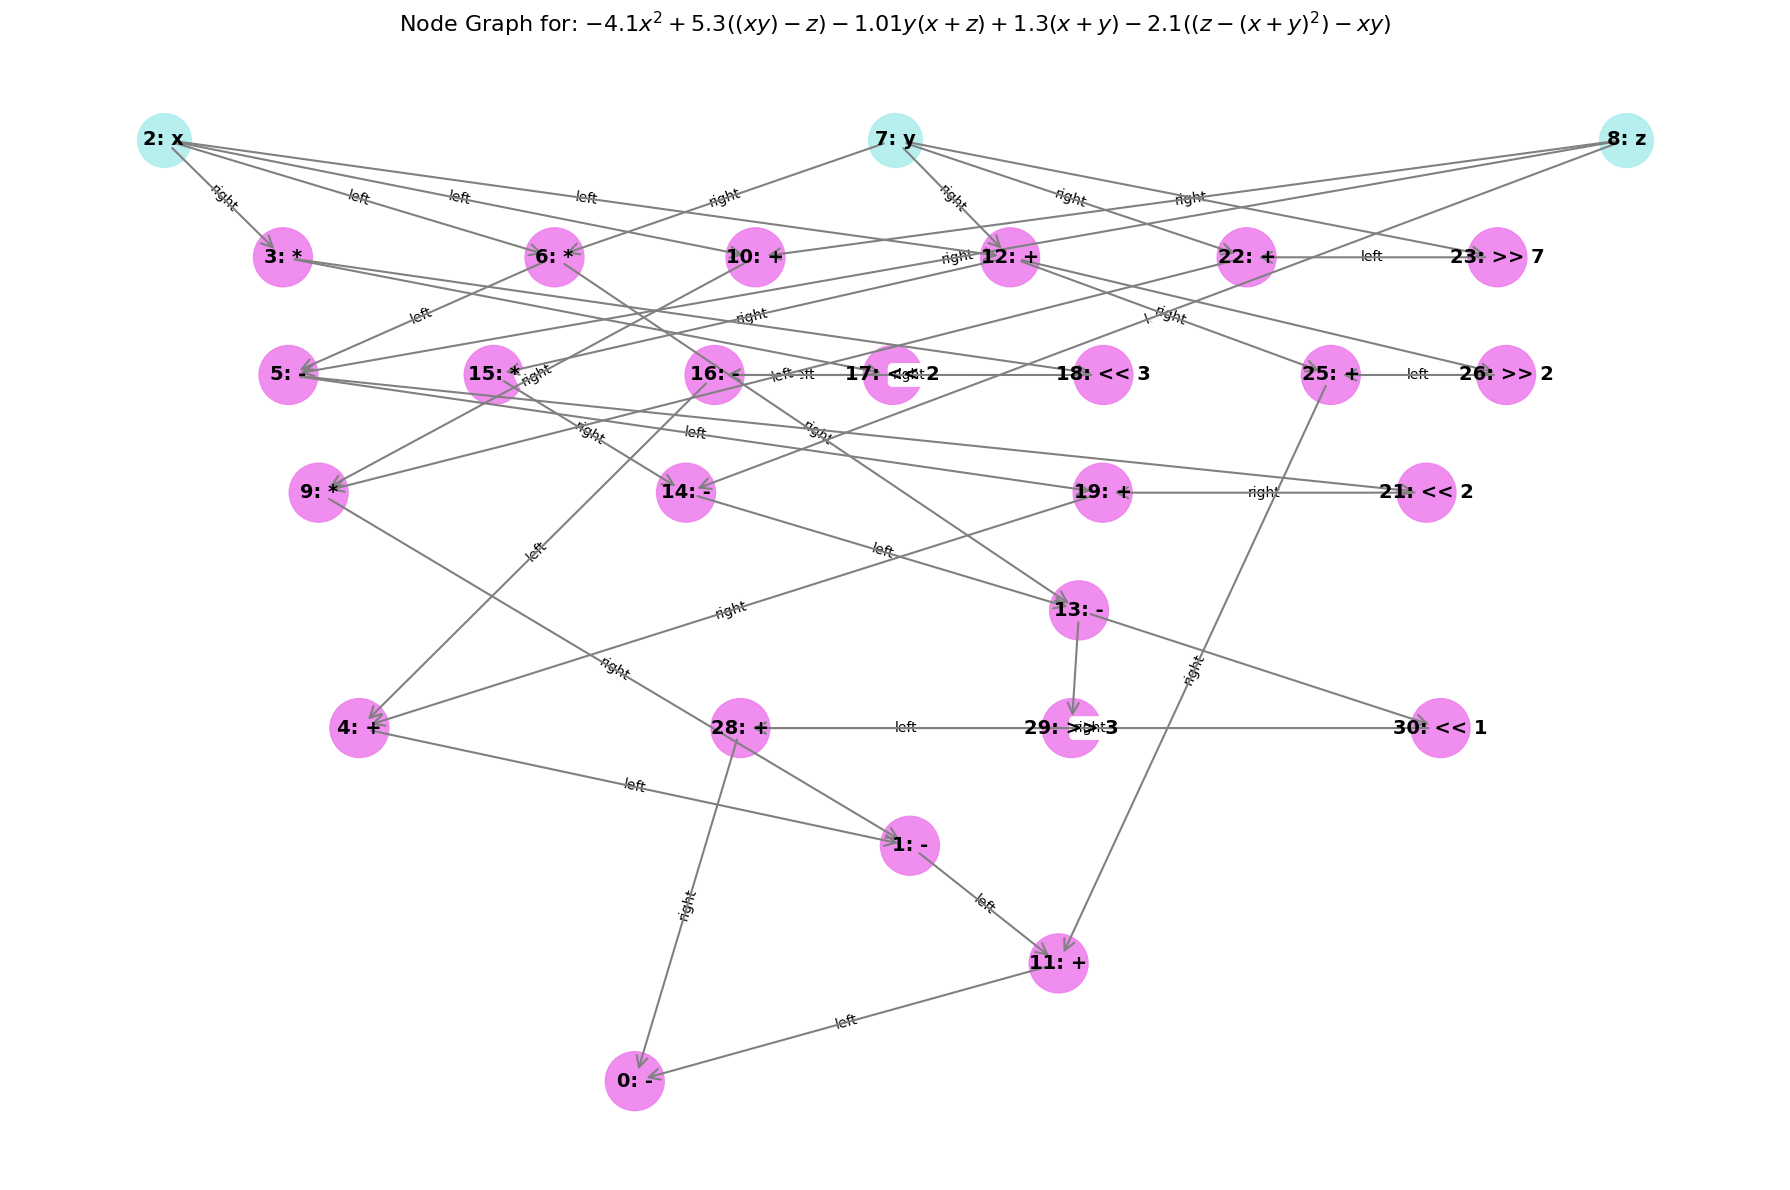

AttributeError: 'DiGraph' object has no attribute 'items'

In [231]:

def test_pos(graph, polynomial_str, pos, specific_node_colors = None):

    if specific_node_colors is None:
        specific_node_colors = {}

    #print(pos)

    plt.figure(figsize=(18, 12))

    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    operation_node_colors = [specific_node_colors.get(node, 'violet') for node in operation_nodes]


    edges = nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
    for edge in edges:
        edge.set_zorder(2)

    nodes = nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color = operation_node_colors, alpha=0.9)
    nodes.set_zorder(1)

    nodes = nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)
    nodes.set_zorder(1)

    edge_labels = nx.get_edge_attributes(graph, 'label')

    # Draw edge labels
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)


    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')

    labels = {}
    for node in graph.nodes():
        attr_value = graph.nodes[node].get('label', '')
        labels[node] = f"{node}: {attr_value}"

    graph_labels = nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')
    for text in graph_labels.values():
        text.set_zorder(3)  # labels on top


    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 



initial_pos = DisplayTree(G_mod, user_input).custom_layout(G_mod)





In [ ]:
test_pos(G_mod, user_input, initial_pos, specific_node_colors= make_color_assignments(DSPSearch.Solver))



In [ ]:
print(new_pos)

DisplayTree(G_mod, user_input, specific_node_colors= make_color_assignments(DSPSearch.Solver), pos = new_pos)


### Optimise x values


In [ ]:
import networkx as nx
import numpy as np
from scipy.optimize import minimize, LinearConstraint
from collections import defaultdict

def calculate_stress(x_coords, G, nodes, initial_y):
    stress = 0.0
    pos_new = {node: (x_coords[i], initial_y[i]) for i, node in enumerate(nodes)}
    
    # Stress term (target distances)
    for u, v in G.edges():
        dx = pos_new[u][0] - pos_new[v][0]
        dy = pos_new[u][1] - pos_new[v][1]
        current_length = np.sqrt(dx**2 + dy**2)
        desired_length = 1.0  # We aim for uniform edge lengths
        stress += (current_length - desired_length)**2
    
    # Node distribution term (avoid overlaps)
    x_sorted = np.sort(x_coords)
    n = len(nodes)
    for i in range(1, n):
        stress += 10.0 / max(0.1, x_sorted[i] - x_sorted[i-1])**2
    
    return stress

def optimize_coordinates(G, pos):
    nodes = list(G.nodes())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    
    # Prepare initial coordinates
    initial_x = np.array([pos[node][0] for node in nodes])
    initial_y = np.array([pos[node][1] for node in nodes])
    
    # Constraints to preserve y-ordering
    constraints = []
    for layer in get_y_layers(pos):
        if len(layer) > 1:
            for i in range(len(layer)-1):
                u = node_index[layer[i]]
                v = node_index[layer[i+1]]
                # Keep original left-to-right order within y-layers
                constraints.append(LinearConstraint(
                    A=np.eye(n)[u] - np.eye(n)[v],
                    lb=0.1, ub=np.inf  # u should be to the left of v
                ))
    
    # Optimize using the external objective function
    res = minimize(
        lambda x: calculate_stress(x, G, nodes, initial_y),
        initial_x,
        method='SLSQP',
        constraints=constraints,
        options={'maxiter': 1000}
    )
    
    optimized_x = res.x
    optimized_pos = {node: (optimized_x[i], initial_y[i]) for i, node in enumerate(nodes)}
    
    return optimized_pos

def get_y_layers(pos):
    y_groups = defaultdict(list)
    for node, (x, y) in pos.items():
        y_groups[round(y, 3)].append(node)
    
    # Sort nodes within each y-layer by their original x-coordinate
    for y in y_groups:
        y_groups[y].sort(key=lambda n: pos[n][0])
    
    return [nodes for y, nodes in sorted(y_groups.items())]




# initial_pos = DisplayTree(G_mod, user_input).custom_layout(G_mod)

# print(initial_pos)

# optimised_pos = optimize_coordinates(G_mod, initial_pos)
# optimised_pos